# Fast Sign Adversary Generation Example

This notebook demos finds adversary examples using MXNet Gluon and taking advantage of the gradient information

[1] Goodfellow, Ian J., Jonathon Shlens, and Christian Szegedy. "Explaining and harnessing adversarial examples." arXiv preprint arXiv:1412.6572 (2014).
https://arxiv.org/abs/1412.6572

In [1]:
%matplotlib inline
import mxnet as mx
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from mxnet import gluon

Build simple CNN network for solving the MNIST dataset digit recognition task

In [17]:
ctx = mx.gpu() if len(mx.test_utils.list_gpus()) else mx.cpu()
batch_size = 128

## Data Loading

In [3]:
transform = lambda x,y: (x.transpose((2,0,1)).astype('float32')/255., y)

train_dataset = gluon.data.vision.MNIST(train=True).transform(transform)
test_dataset = gluon.data.vision.MNIST(train=False).transform(transform)

train_data = gluon.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=5)
test_data = gluon.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Create the network

In [4]:
net = gluon.nn.HybridSequential()
with net.name_scope():
    net.add(
        gluon.nn.Conv2D(kernel_size=5, channels=20, activation='tanh'),
        gluon.nn.MaxPool2D(pool_size=2, strides=2),
        gluon.nn.Conv2D(kernel_size=5, channels=50, activation='tanh'),
        gluon.nn.MaxPool2D(pool_size=2, strides=2),
        gluon.nn.Flatten(),
        gluon.nn.Dense(500, activation='tanh'),
        gluon.nn.Dense(10)
    )

## Initialize training

In [5]:
net.initialize(mx.initializer.Uniform(), ctx=ctx)
net.hybridize()

In [6]:
loss = gluon.loss.SoftmaxCELoss()

In [7]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1, 'momentum':0.95})

## Training loop

In [8]:
epoch = 3
for e in range(epoch):
    train_loss = 0.
    acc = mx.metric.Accuracy()
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        
        with mx.autograd.record():
            output = net(data)
            l = loss(output, label)
            
        l.backward()
        trainer.update(data.shape[0])
        
        train_loss += l.mean().asscalar()
        acc.update(label, output)
    
    print("Train Accuracy: %.2f\t Train Loss: %.5f" % (acc.get()[1], train_loss/(i+1)))

Train Accuracy: 0.92	 Train Loss: 0.32142
Train Accuracy: 0.97	 Train Loss: 0.16773
Train Accuracy: 0.97	 Train Loss: 0.14660


## Perturbation

We first run a validation batch and measure the resulting accuracy.
We then perturbate this batch by modifying the input in the opposite direction of the gradient.

In [9]:
# Get a batch from the testing set
for data, label in test_data:
    data = data.as_in_context(ctx)
    label = label.as_in_context(ctx)
    break

# Attach gradient to it to get the gradient of the loss with respect to the input
data.attach_grad()
with mx.autograd.record():
    output = net(data)    
    l = loss(output, label)
l.backward()

acc = mx.metric.Accuracy()
acc.update(label, output)

print("Validation batch accuracy {}".format(acc.get()[1]))

Validation batch accuracy 0.96875


Now we perturb the input

In [10]:
data_perturbated = data + 0.15 * mx.nd.sign(data.grad)

output = net(data_perturbated)    

acc = mx.metric.Accuracy()
acc.update(label, output)

print("Validation batch accuracy after perturbation {}".format(acc.get()[1]))

Validation batch accuracy after perturbation 0.40625


## Visualization

Let's visualize an example after pertubation.

We can see that the prediction is often incorrect.

true label: 1
predicted: 3


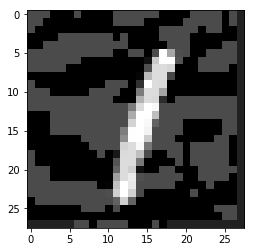

In [16]:
from random import randint
idx = randint(0, batch_size-1)

plt.imshow(data_perturbated[idx, :].asnumpy().reshape(28,28), cmap=cm.Greys_r)
print("true label: %d" % label.asnumpy()[idx])
print("predicted: %d" % np.argmax(output.asnumpy(), axis=1)[idx])